In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import scipy.optimize as opt
import os

In [8]:
def plot_voltage_temp(dataset, title = ''):
    plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
    fig, axs = plt.subplots(4, 2, figsize=(8, 8), dpi=200)
    fig.suptitle(title)

    for i in range(1, 8):
        ax = axs[(i-1)//2, (i-1)%2]
        ax.scatter(1/dataset['T'], dataset[f'v{i}'], s=5)
        ax.set_title(f'v{i}')

    fig.supxlabel('T (1/K)')
    fig.supylabel('Voltage (V)')
    plt.tight_layout()
    plt.show() 

## Load Data

In [9]:
user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents'

In [10]:
# No magnet or magnetic field
onemA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/1mA_no_magnet_3.csv', header=2)
threemA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/3mA_no_magnet.csv', header=2)
tenmA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/10mA_no_magnet.csv', header=2)
thirtymA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/30mA_no_magnet.csv', header=2)

## 1. No Heating or Magnetic field

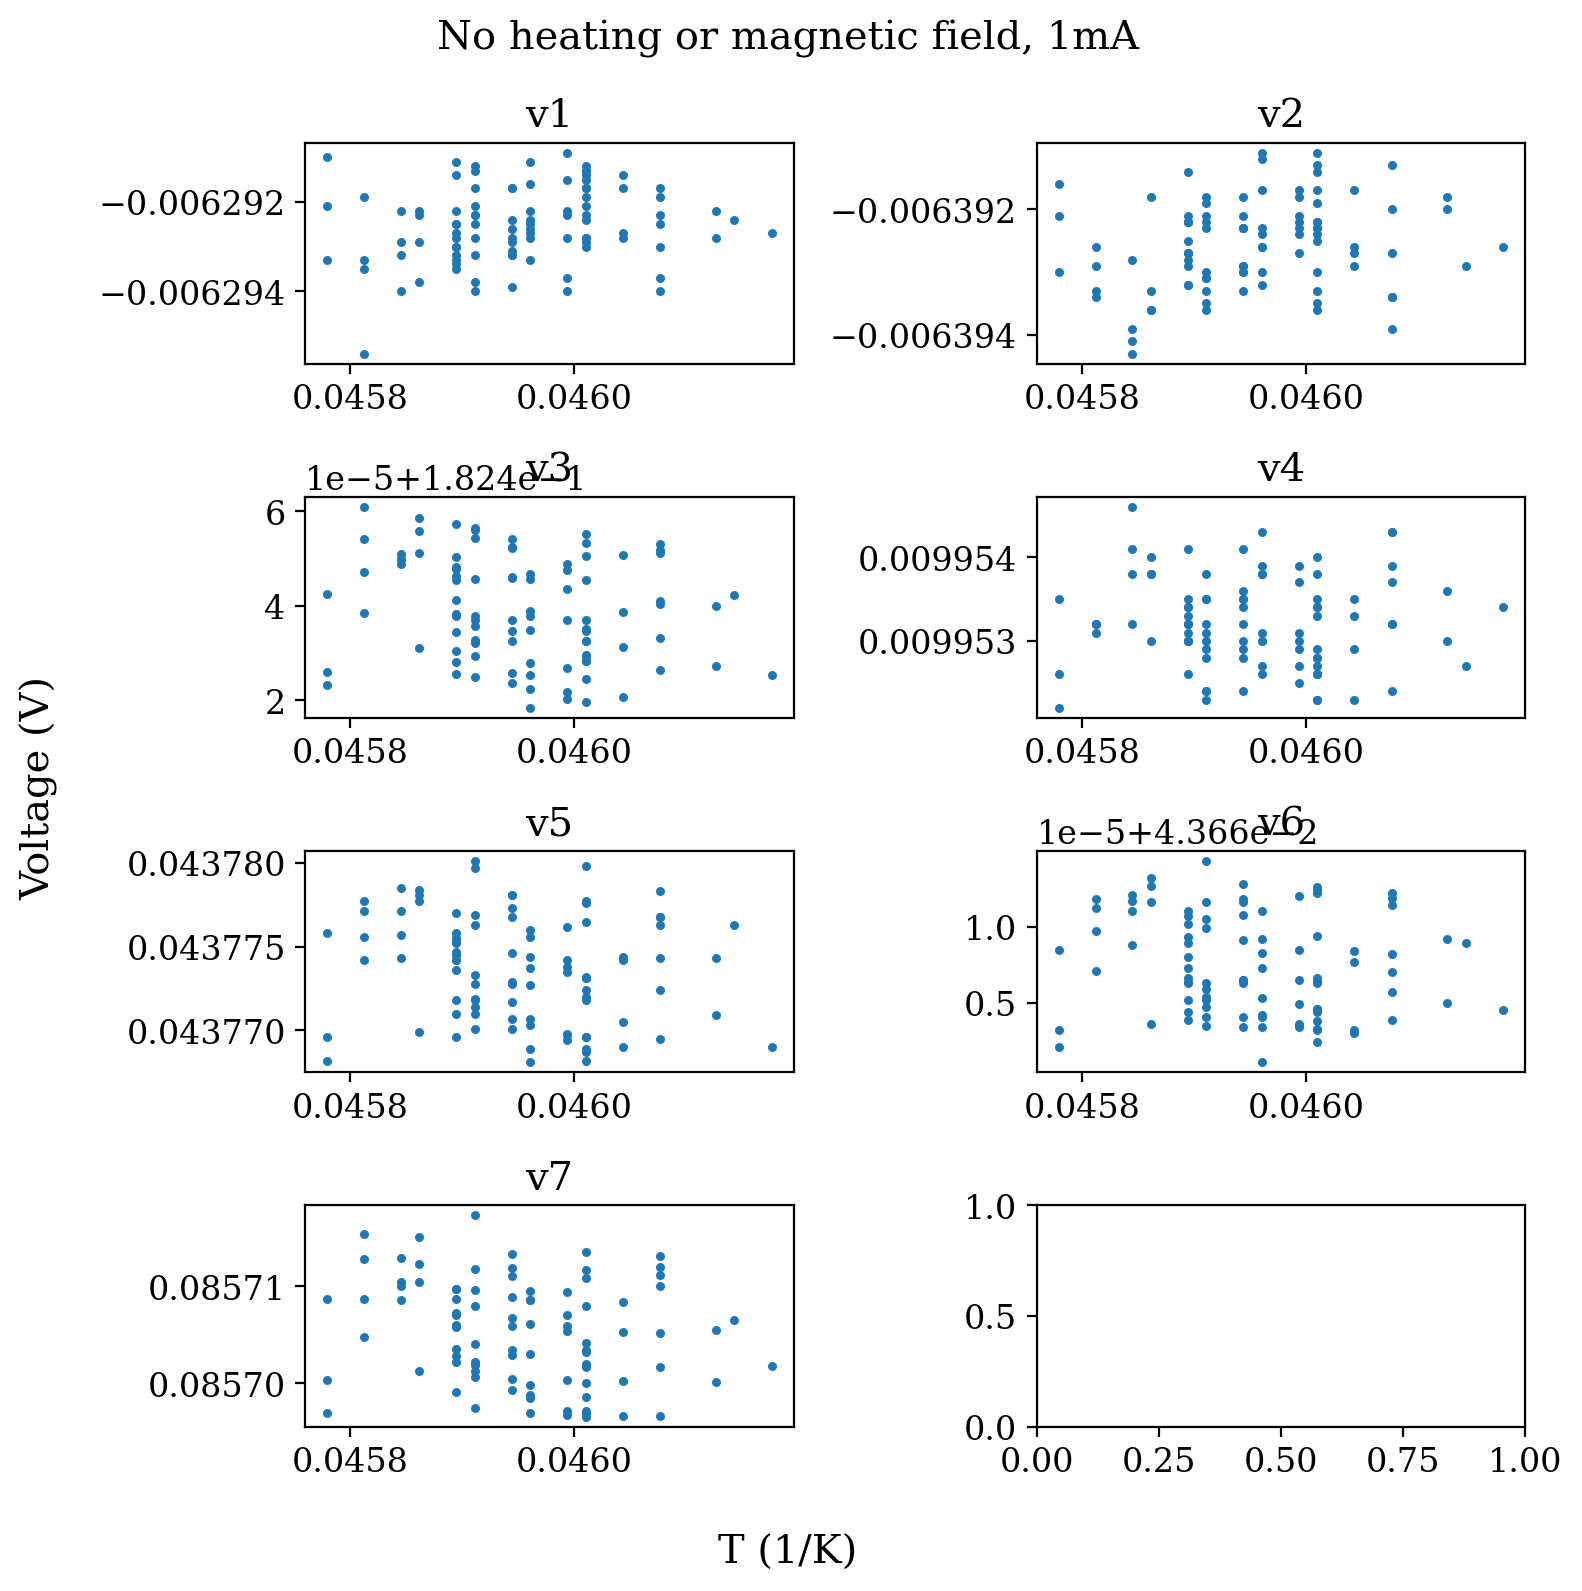

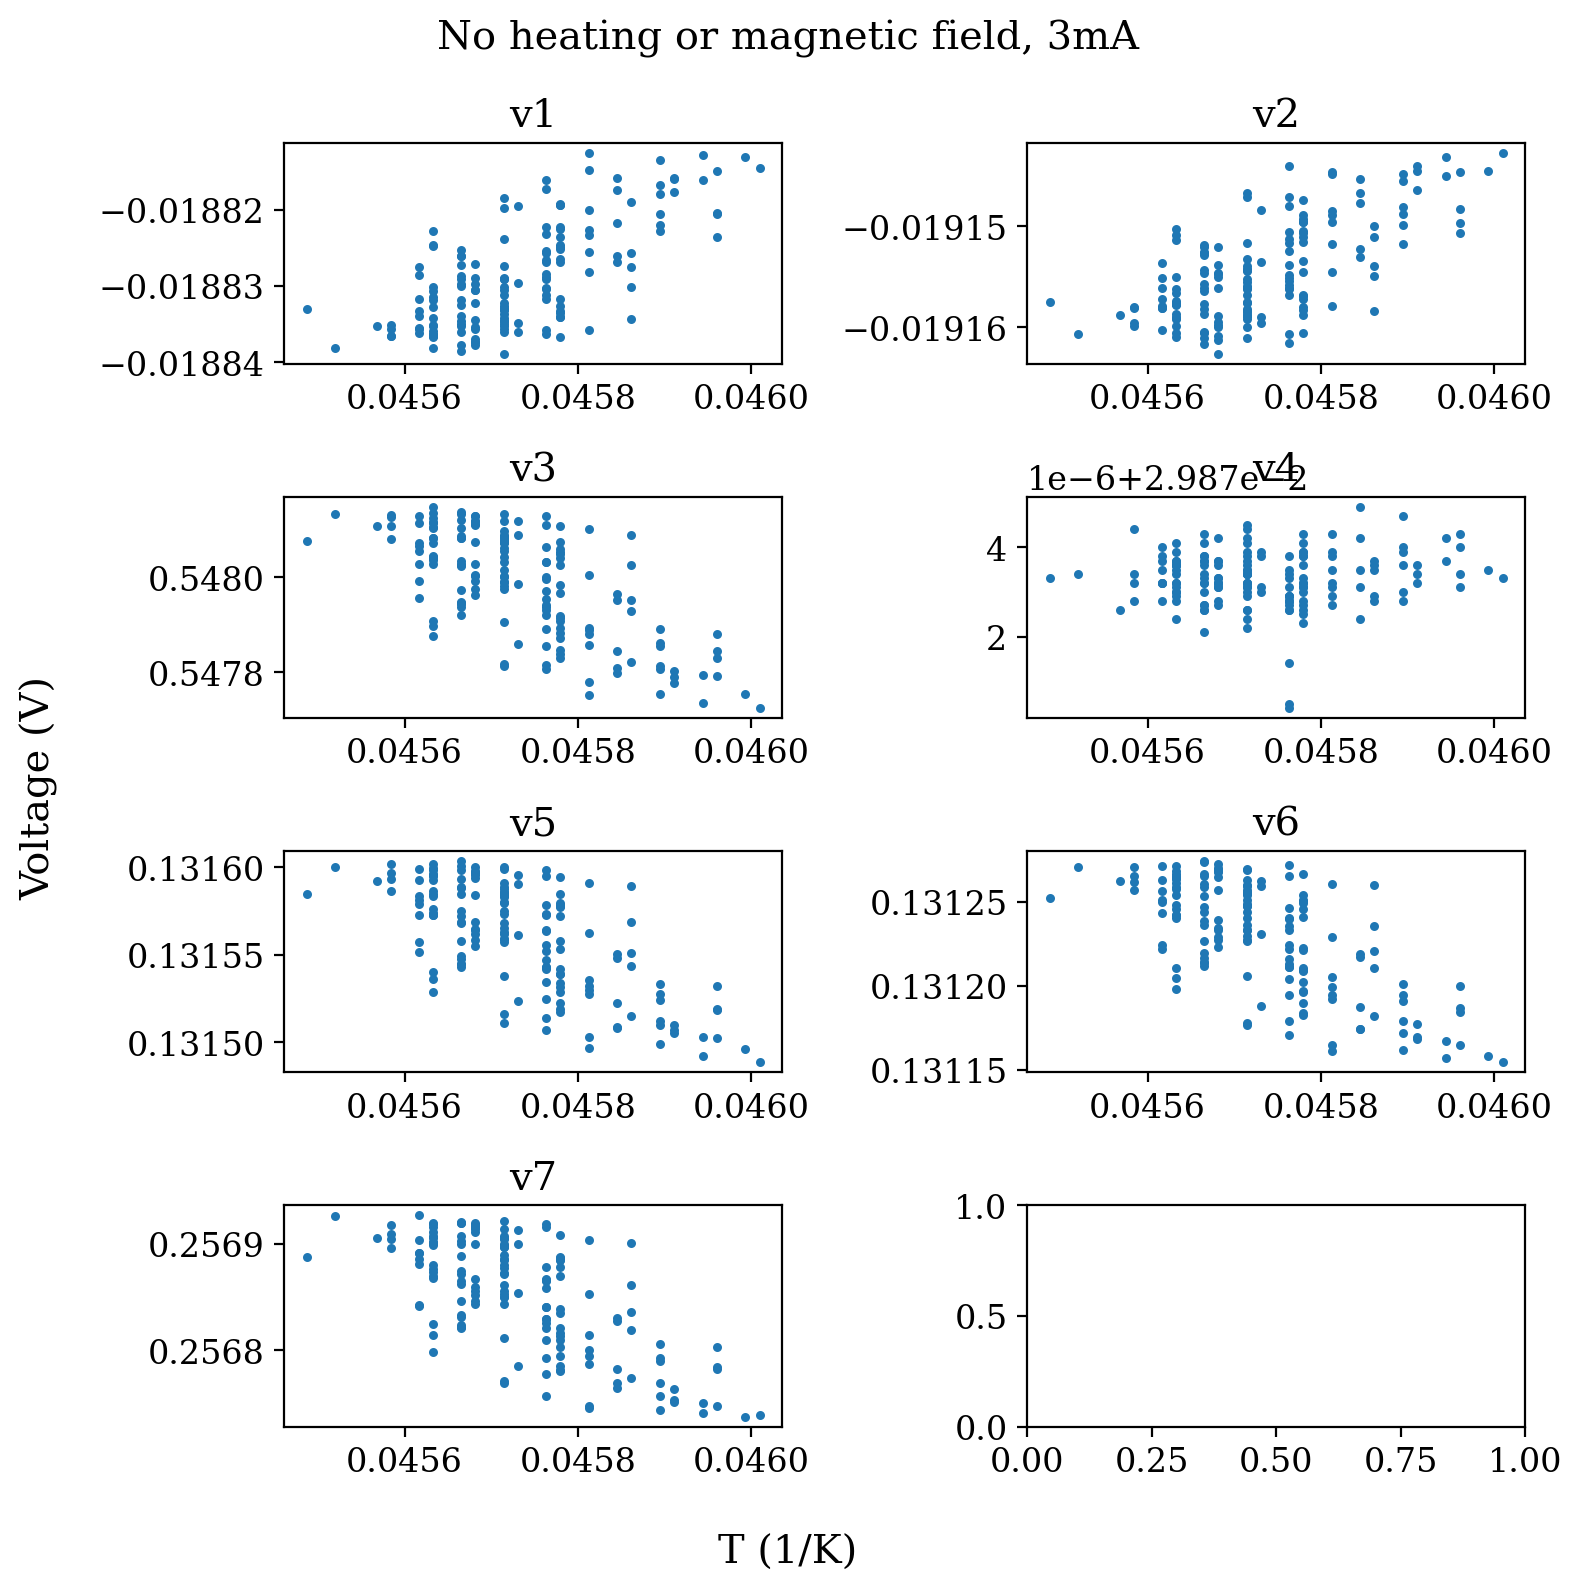

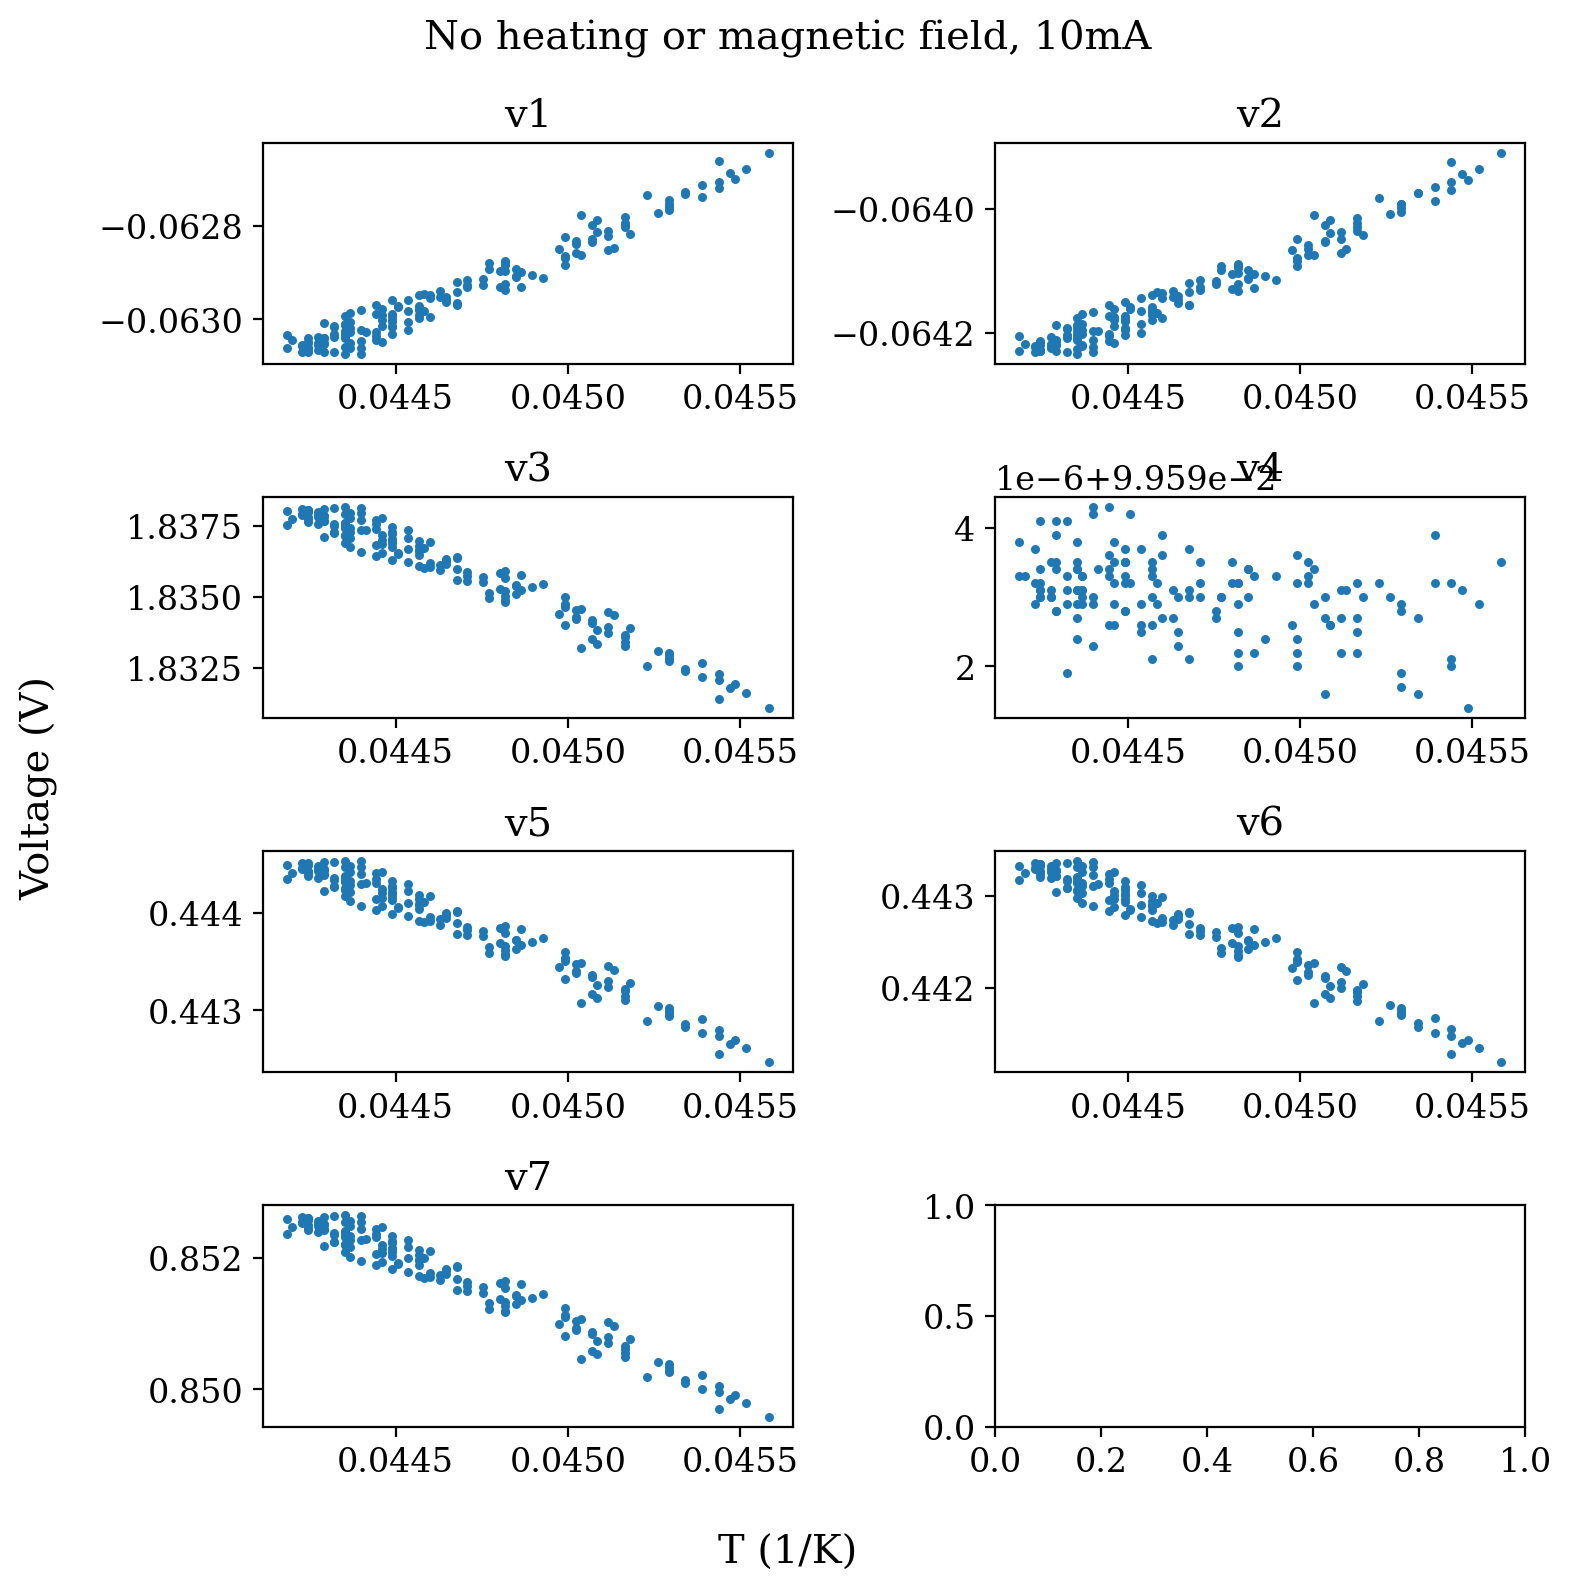

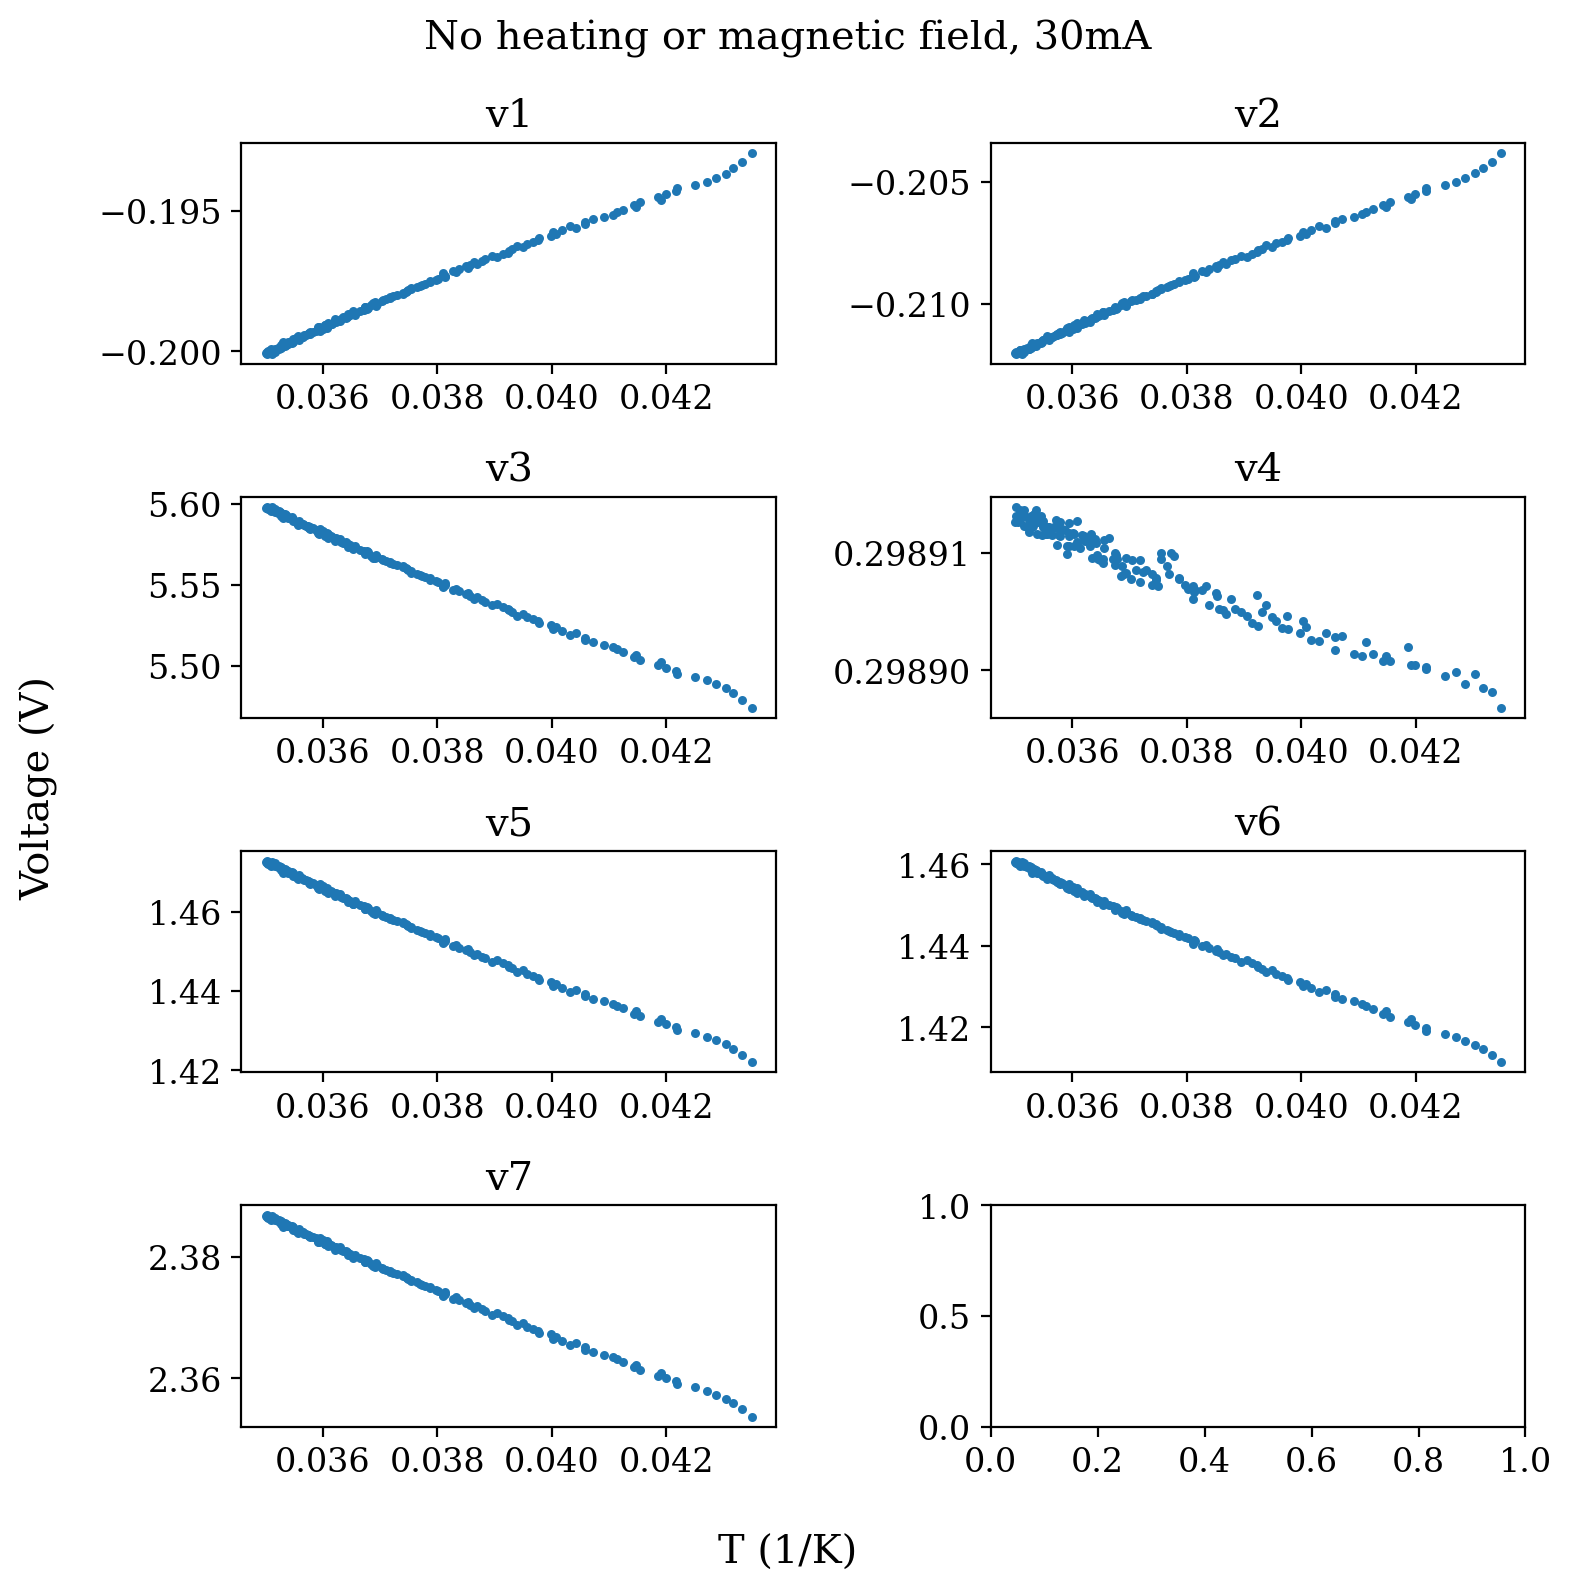

In [11]:
# load csv using pandas\n ,
onemA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/1mA_no_magnet_3.csv', header=2)
plot_voltage_temp(onemA_no_magnet, 'No heating or magnetic field, 1mA')

threemA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/3mA_no_magnet.csv', header=2)
plot_voltage_temp(threemA_no_magnet, 'No heating or magnetic field, 3mA')

tenmA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/10mA_no_magnet.csv', header=2)
plot_voltage_temp(tenmA_no_magnet, 'No heating or magnetic field, 10mA')

thirtymA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/30mA_no_magnet.csv', header=2)
plot_voltage_temp(thirtymA_no_magnet, 'No heating or magnetic field, 30mA') 

## Interpolation

In [12]:
def interp_data(dataset, new_path=''):
    interp_dataset = dict()
    common_time = dataset["t9"]  # using time of temperature readings

    interp_dataset['t'] = common_time

    for i in range(1, 8):
        interp_data = interp1d(dataset[f't{i}'], dataset[f'v{i}'], bounds_error=False, fill_value="extrapolate")
        interp_dataset[f'v{i}'] = interp_data(common_time)

    np.savez(f'{new_path}.npz', interp_dataset)
    interp_dataset['T'] = dataset['T']
    return interp_dataset

## Interim Report Plots

### Raw measurement plot

In [13]:
# loading one of the heated, magnetic field datasets we took on the 12th

path = user_path+'/PHYS469/hall_experiment/09122024/300mV_10mA_heating.csv'
data = pd.read_csv(path, header=2)
dict = interp_data(data, '300mV_10mA_heating')

In [14]:
# fitting the linear part of the data
# sigma = IL/VA * exp(Eg/2kT), so if we plot ln(1/V) vs 1/T, we should get a straight line

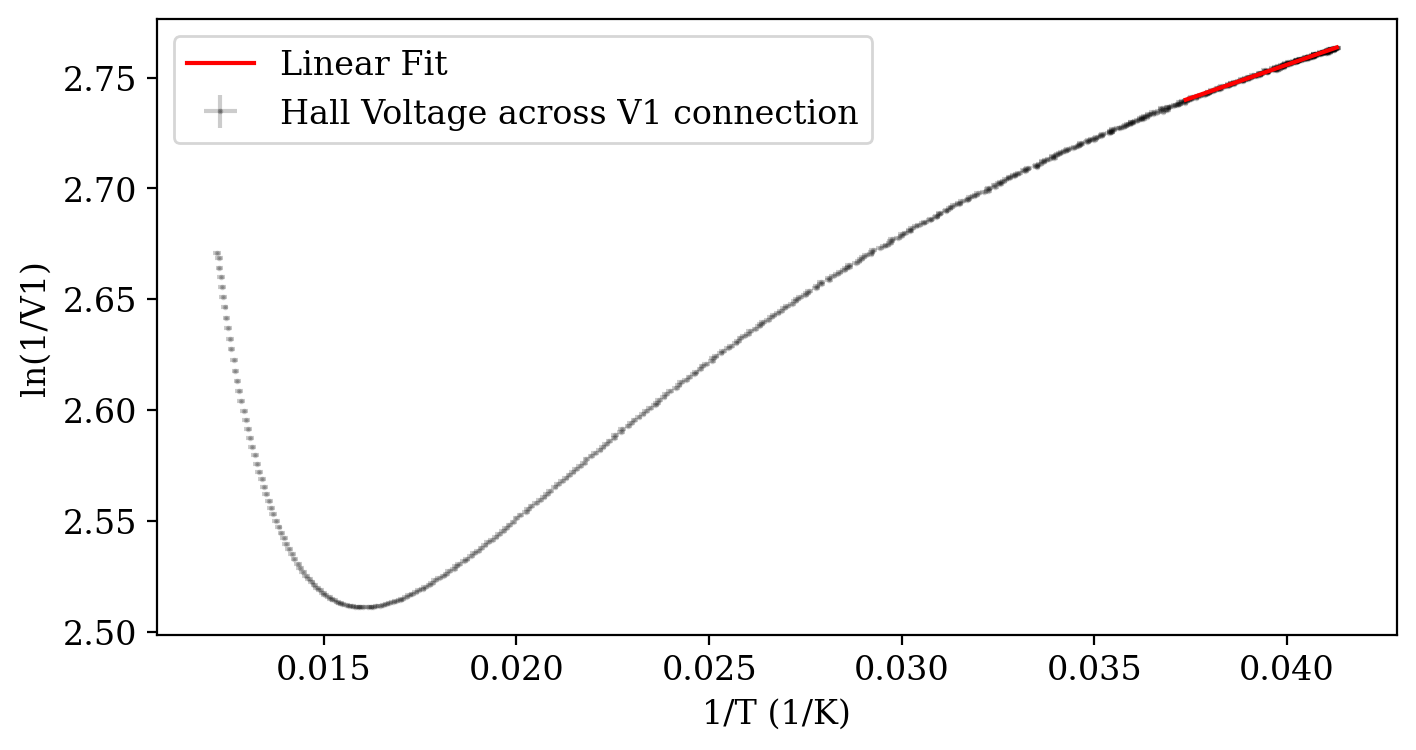

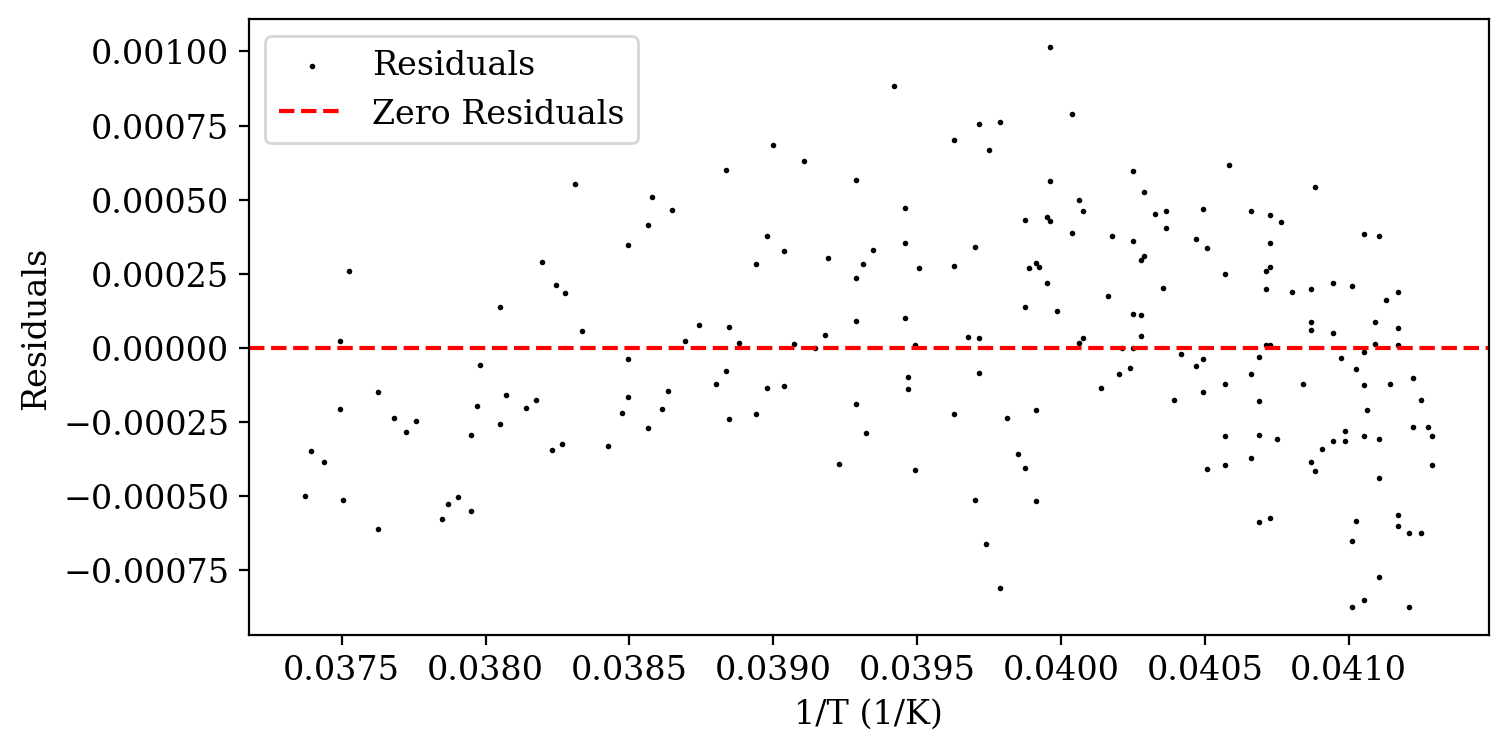

In [15]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4), dpi=200)
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

# Plot the original data points
plt.errorbar(1/data['T'], np.log(np.abs(1/dict['v1'])), xerr=0.0001, yerr=0.0000001, fmt='o', markersize=1, label='Hall Voltage across V1 connection', alpha=0.2, zorder = 1, color = 'black')
plt.xlabel('1/T (1/K)')
plt.ylabel('ln(1/V1)')

# Perform a linear fit on the specified section of the data
coefficients = np.polyfit((1/data['T'])[350:], np.log(np.abs(1/dict['v1'][350:])), 1)
polynomial = np.poly1d(coefficients)

# Generate x values for the fitted line
T_fit = np.linspace((1/data['T'])[350], (1/data['T']).max(), 100)
V1_fit = polynomial(T_fit)

# Plot the fitted line on top of the original data points
plt.plot(T_fit, V1_fit, label='Linear Fit', color='red')

plt.legend(loc='upper left')

# plot residuals for the area of the fit
plt.figure(figsize=(8, 4), dpi=200)
plt.scatter(1/data['T'][350:], np.log(np.abs(1/dict['v1'][350:])) - polynomial(1/data['T'][350:]), s=1,  label='Residuals', zorder = 1, color = 'black')
plt.xlabel('1/T (1/K)')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Residuals')
plt.legend(loc='upper left')


# FOR AUDREY;
# I think the uncertainty on the Thermocouple is 0.0001, and 0.0000001 on V1

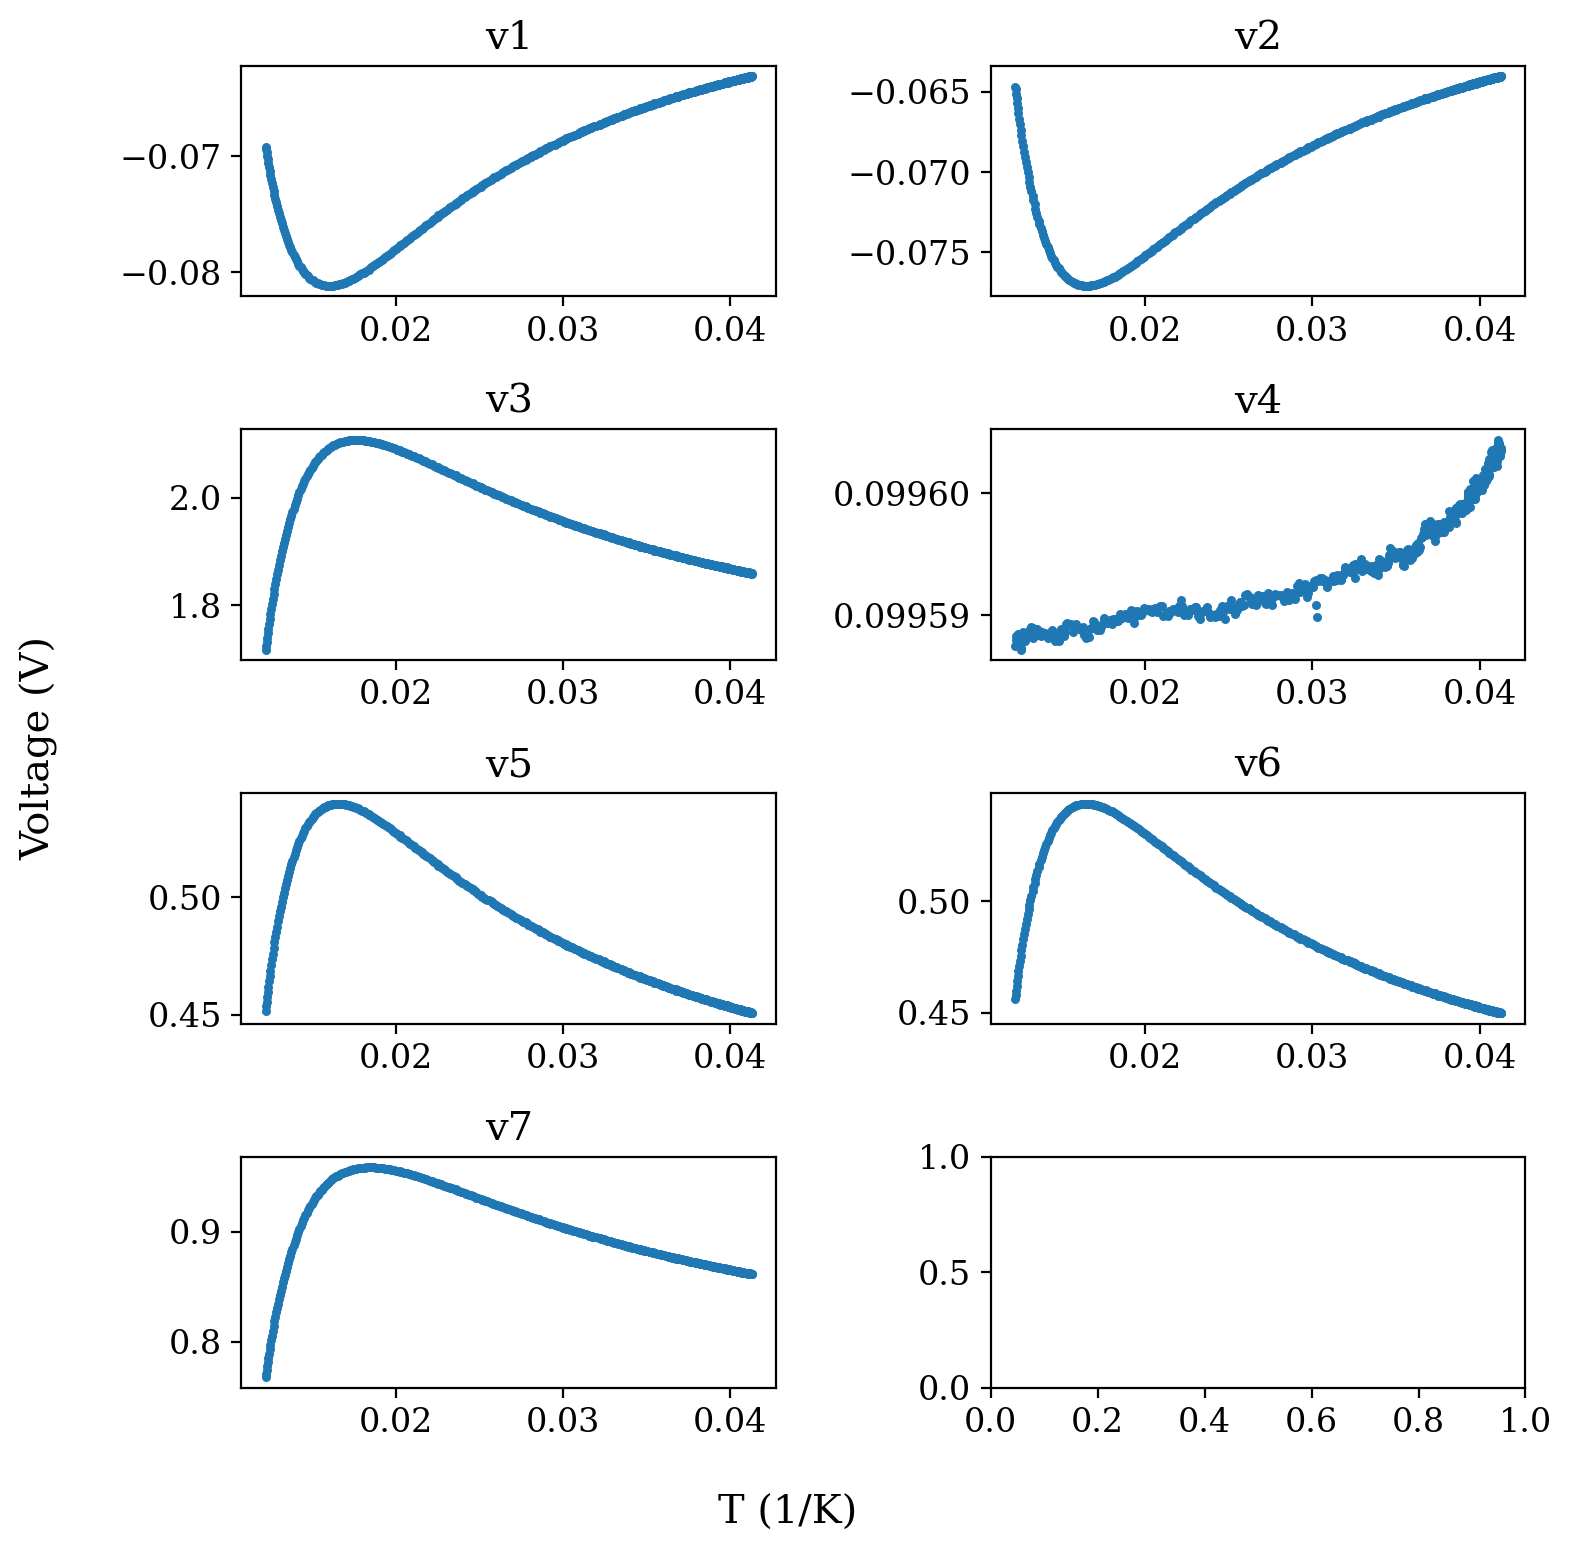

In [16]:
plot_voltage_temp(dict)

<!--  -->

TO DO: 
- calculate the base conductivity
- calculate the band gap energy